<a href="https://colab.research.google.com/github/1hamzaiqbal/MFCLIP_acv/blob/hamza%2Fdiscrim/tsne_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# t-SNE visualization for CLIP features

This notebook:
1. Sets up the repo and environment (Colab-ready)
2. Downloads Oxford Pets dataset
3. Extracts CLIP image features and labels
4. Runs t-SNE visualization to show discrimination ability


In [6]:
# 0) GPU + repo setup
!nvidia-smi
%cd /content
!git clone -b hamza/discrim https://github.com/1hamzaiqbal/MFCLIP_acv
%cd MFCLIP_acv



Tue Nov  4 02:32:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   43C    P8             17W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
# 1) Install dependencies
!pip install torch torchvision timm einops yacs tqdm opencv-python scikit-learn scipy pyyaml ruamel.yaml pytorch-ignite foolbox pandas matplotlib seaborn wilds ftfy



In [8]:
# 2) Download Oxford Pets dataset
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
from pathlib import Path

root = Path("/content/data/oxford_pets")
root.mkdir(parents=True, exist_ok=True)
_ = OxfordIIITPet(root=str(root), download=True, transform=transforms.ToTensor())
print("Oxford Pets downloaded to", root)

# Also fetch annotations
%cd /content
!mkdir -p /content/data/oxford_pets
!wget -q https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget -q https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz -C /content/data/oxford_pets
!tar -xf annotations.tar.gz -C /content/data/oxford_pets
!ls /content/data/oxford_pets/annotations | head



Oxford Pets downloaded to /content/data/oxford_pets
/content
list.txt
README
test.txt
trainval.txt
trimaps
xmls


In [9]:
# 3) Extract features for t-SNE visualization
# Change split to "train", "val", or "test" as needed
%cd /content/MFCLIP_acv
%env TF_CPP_MIN_LOG_LEVEL=2

split = "test"  # Can change to "train" or "val"

import subprocess
import sys
import os

# Set PYTHONPATH to include repo root so imports work correctly
env = os.environ.copy()
repo_root = "/content/MFCLIP_acv"
env["PYTHONPATH"] = f"{repo_root}:{env.get('PYTHONPATH', '')}"

# The feat_extractor.py script expects to be run from lpclip/ directory
# It does sys.path.append("..") to add repo root, but PYTHONPATH ensures it works
cmd = [
    sys.executable, "feat_extractor.py",
    "--root", "/content/data",
    "--output-dir", "/content/MFCLIP_acv/clip_feat",
    "--config-file", "../configs/trainers/CoOp/rn50.yaml",
    "--dataset-config-file", "../configs/datasets/oxford_pets.yaml",
    "--split", split
]

print(f"Running feature extraction for split: {split}")
print(f"Working directory: /content/MFCLIP_acv/lpclip")
print(f"PYTHONPATH: {env['PYTHONPATH']}")

# Run from lpclip/ directory so imports work correctly
result = subprocess.run(cmd, cwd="/content/MFCLIP_acv/lpclip", env=env, capture_output=True, text=True)
print(result.stdout)
if result.returncode != 0:
    print("Error:", result.stderr)
    raise RuntimeError("Feature extraction failed")

# Verify output exists
npz_path = f"/content/MFCLIP_acv/clip_feat/OxfordPets/{split}.npz"
assert os.path.exists(npz_path), f"Features not found at {npz_path}"
print(f"\nFeatures extracted successfully to: {npz_path}")



/content/MFCLIP_acv
env: TF_CPP_MIN_LOG_LEVEL=2
Running feature extraction for split: test
Working directory: /content/MFCLIP_acv/lpclip
PYTHONPATH: /content/MFCLIP_acv:/env/python
***************
** Arguments **
***************
backbone: 
config_file: ../configs/trainers/CoOp/rn50.yaml
dataset_config_file: ../configs/datasets/oxford_pets.yaml
eval_only: False
head: 
num_shot: 1
output_dir: /content/MFCLIP_acv/clip_feat
root: /content/data
seed: -1
split: test
trainer: 
************
** Config **
************
DATALOADER:
  BS: 128
  K_TRANSFORMS: 1
  NUM_WORKERS: 16
  RETURN_IMG0: False
  TEST:
    BATCH_SIZE: 100
    SAMPLER: SequentialSampler
  TRAIN_U:
    BATCH_SIZE: 32
    N_DOMAIN: 0
    N_INS: 16
    SAME_AS_X: True
    SAMPLER: RandomSampler
  TRAIN_X:
    BATCH_SIZE: 256
    N_DOMAIN: 0
    N_INS: 16
    SAMPLER: RandomSampler
DATASET:
  ALL_AS_UNLABELED: False
  CIFAR_C_LEVEL: 1
  CIFAR_C_TYPE: 
  NAME: OxfordPets
  NUM_LABELED: -1
  NUM_SHOTS: -1
  ROOT: /content/data
  SOURC

Features shape: (3669, 1024), Labels shape: (3669,)
Number of classes: 37
Running t-SNE with perplexity=30...
t-SNE completed!

Saved visualization to: /content/MFCLIP_acv/tsne_test.png


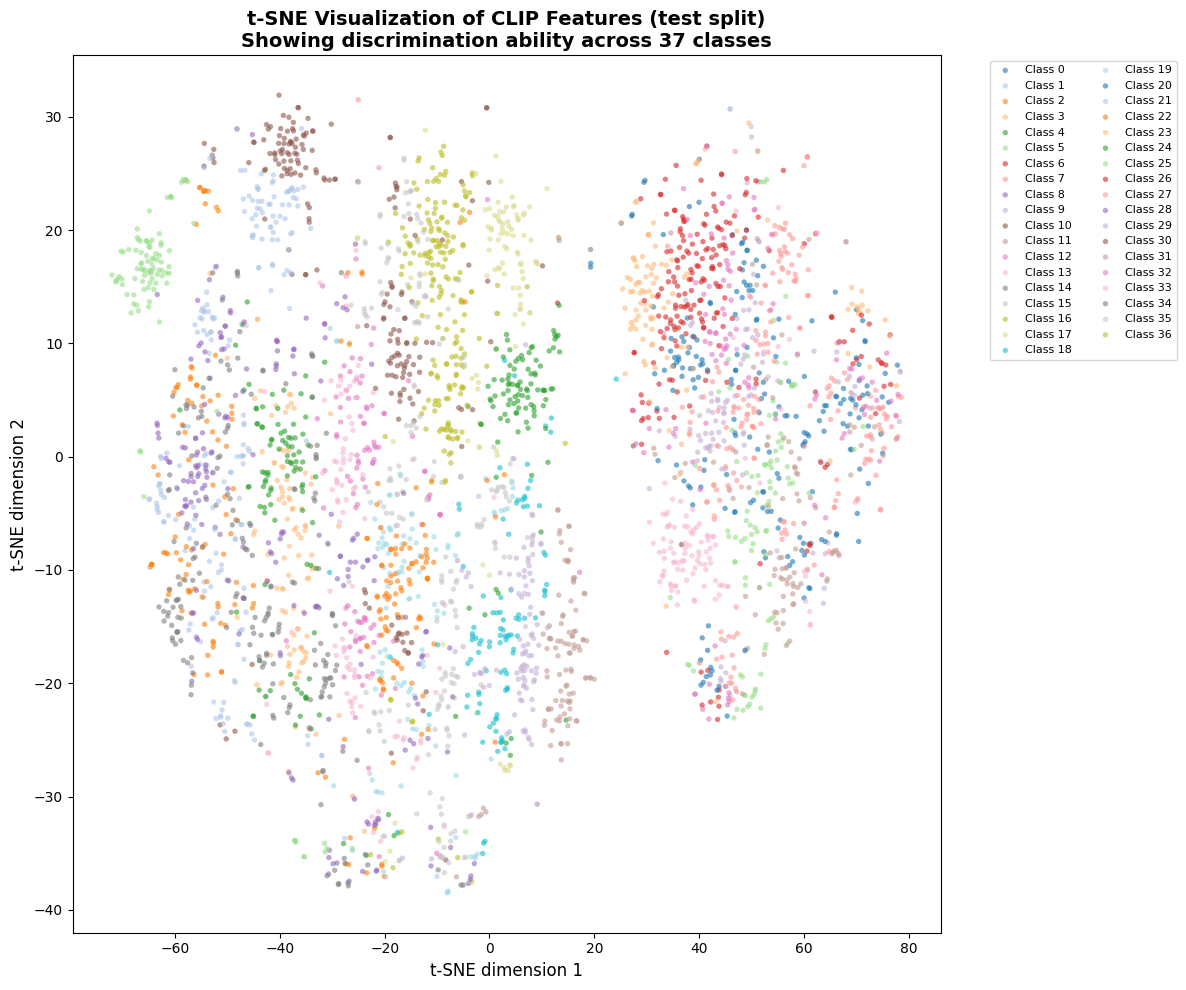


Statistics:
  - Total samples: 3669
  - Number of classes: 37
  - Samples per class: [ 98 100 100 100 100 100 100  88  99 100 100  97 100 100 100 100 100 100
  99 100 100 100 100 100 100 100 100 100 100 100  99 100 100 100  89 100
 100]


In [12]:
# 4) Run t-SNE visualization
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Load features and labels
npz = np.load(npz_path)
X = np.array(npz["feature_list"], dtype=np.float32)
y = np.array(npz["label_list"], dtype=np.int32)
print(f"Features shape: {X.shape}, Labels shape: {y.shape}")
print(f"Number of classes: {len(np.unique(y))}")

# Optional subsample for faster computation and clearer plots
max_points = 4000
if len(X) > max_points:
    rng = np.random.default_rng(0)
    idx = rng.choice(len(X), size=max_points, replace=False)
    X = X[idx]
    y = y[idx]
    print(f"Subsampled to {len(X)} points for plotting")

# Run t-SNE
perplexity = min(30, max(5, len(X)//100))  # Adaptive perplexity
print(f"Running t-SNE with perplexity={perplexity}...")
tsne = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=perplexity, random_state=0, max_iter=1000)
Z = tsne.fit_transform(X)
print("t-SNE completed!")

# Plot
plt.figure(figsize=(12, 10))
unique_labels = np.unique(y)
palette = sns.color_palette("tab20", n_colors=len(unique_labels))

for i, cls in enumerate(unique_labels):
    mask = (y == cls)
    plt.scatter(Z[mask, 0], Z[mask, 1], s=15, color=palette[i % len(palette)],
                label=f"Class {cls}", alpha=0.6, edgecolors='none')

plt.title(f"t-SNE Visualization of CLIP Features ({split} split)\nShowing discrimination ability across {len(unique_labels)} classes",
          fontsize=14, fontweight='bold')
plt.xlabel("t-SNE dimension 1", fontsize=12)
plt.ylabel("t-SNE dimension 2", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=2)
plt.tight_layout()

# Save figure
output_path = f"/content/MFCLIP_acv/tsne_{split}.png"
plt.savefig(output_path, dpi=200, bbox_inches='tight')
print(f"\nSaved visualization to: {output_path}")
plt.show()

# Print some statistics
print(f"\nStatistics:")
print(f"  - Total samples: {len(y)}")
print(f"  - Number of classes: {len(unique_labels)}")
print(f"  - Samples per class: {np.bincount(y)}")
